# Model D: Stage 1 vs Stage 2 Classification

Binary classification to distinguish between **Stage 1** and **Stage 2** liver cirrhosis.

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'sans-serif'

In [43]:
# Load Data
df = pd.read_csv('cirrhosis.csv')

if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

df = df.dropna(subset=['Stage'])

# Filter: Only Stages 1 and 2
df_d = df[df['Stage'].isin([1, 2])].copy()

print(f"Filtered Shape (Stages 1 and 2 only): {df_d.shape}")
print("\nStage Distribution:")
print(df_d['Stage'].value_counts().sort_index())

Filtered Shape (Stages 1 and 2 only): (16706, 19)

Stage Distribution:
Stage
1    8265
2    8441
Name: count, dtype: int64


## 1. Target Definition
**Stage 1 (Early) vs Stage 2 (Moderate)**

In [44]:
# Binary target: 0 if Stage 1, 1 if Stage 2
df_d['Target'] = (df_d['Stage'] == 2).astype(int)

print("Binary Target Distribution (Model D):")
print(df_d['Target'].value_counts())
print(f"\nStage 1 (0): {(df_d['Target'] == 0).sum()}")
print(f"Stage 2 (1): {(df_d['Target'] == 1).sum()}")

Binary Target Distribution (Model D):
Target
1    8441
0    8265
Name: count, dtype: int64

Stage 1 (0): 8265
Stage 2 (1): 8441


## 2. Log Transformation + Winsorization

In [45]:
# Log Transformation + Winsorization (same as Model B)
log_transform_cols = ['Bilirubin', 'Copper', 'Alk_Phos', 'Tryglicerides', 'SGOT', 'Prothrombin', 'Cholesterol']

print("Step 1: Applying Log Transformation...")
df_transformed_d = df_d.copy()
for col in log_transform_cols:
    if col in df_transformed_d.columns:
        df_transformed_d[col] = np.log1p(df_transformed_d[col])
        print(f"  - {col}: log-transformed")

winsor_cols = log_transform_cols

# Apply Stage-Specific Winsorization
clipped_df = df_transformed_d.copy()
stages = clipped_df['Stage'].unique()

print("\nStep 2: Applying Stage-specific Winsorization...")
for stage in stages:
    stage_mask = (clipped_df['Stage'] == stage)
    for col in winsor_cols:
        if col in clipped_df.columns:
            stage_data = clipped_df.loc[stage_mask, col]
            Q1 = stage_data.quantile(0.25)
            Q3 = stage_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            clipped_df.loc[stage_mask, col] = stage_data.clip(lower=lower_bound, upper=upper_bound)
print("Winsorization complete!")

df_d_clean = clipped_df

Step 1: Applying Log Transformation...
  - Bilirubin: log-transformed
  - Copper: log-transformed
  - Alk_Phos: log-transformed
  - Tryglicerides: log-transformed
  - SGOT: log-transformed
  - Prothrombin: log-transformed
  - Cholesterol: log-transformed

Step 2: Applying Stage-specific Winsorization...
Winsorization complete!


## 3. Feature Engineering

In [46]:
def medical_feature_engineering(df_input):
    df_eng = df_input.copy()
    
    # Age conversion
    df_eng['Age_Year'] = df_eng['Age'] / 365.25
    
    # Unit conversions
    df_eng['bili_umolL'] = df_eng['Bilirubin'] * 17.1
    df_eng['alb_gL'] = df_eng['Albumin'] * 10
    df_eng['plt_1000uL'] = df_eng['Platelets'] / 1000
    
    # ALBI Score
    df_eng['ALBI'] = (np.log10(df_eng['bili_umolL']) * 0.66) + (df_eng['alb_gL'] * -0.085)
    
    # PALBI Score  
    df_eng['PALBI'] = (df_eng['ALBI'] * 1.0) + (df_eng['plt_1000uL'] * -0.04)
    
    # APRI
    df_eng['APRI'] = (df_eng['SGOT'] / 40) / df_eng['plt_1000uL']
    
    # FIB-4
    df_eng['FIB4'] = (df_eng['Age_Year'] * df_eng['SGOT']) / (df_eng['plt_1000uL'] * np.sqrt(df_eng['Bilirubin']))
    
    # Bilirubin/Platelets
    df_eng['Bili_Platelet_Ratio'] = df_eng['Bilirubin'] / (df_eng['Platelets'] + 1)
    
    # Copper×Bilirubin
    df_eng['Copper_Bili_Interaction'] = df_eng['Copper'] * df_eng['Bilirubin']
    
    return df_eng

df_d_fe = medical_feature_engineering(df_d_clean)
print("Medical features engineered!")
print(df_d_fe[['ALBI', 'PALBI', 'APRI', 'FIB4']].describe())

Medical features engineered!
               ALBI         PALBI          APRI          FIB4
count  16706.000000  16706.000000  16706.000000  16706.000000
mean      -2.257127     -2.267985      0.494063   1082.257060
std        0.371164      0.371602      0.203535    557.260283
min       -3.394745     -3.409185      0.136059    203.331537
25%       -2.526038     -2.535416      0.362029    689.757168
50%       -2.271856     -2.289031      0.447717    980.247401
75%       -1.999598     -2.007860      0.562698   1330.633424
max       -0.739539     -0.748099      1.942500   5464.207790


## 3.5. Exploratory Data Analysis (EDA)

EXPLORATORY DATA ANALYSIS - ALL FEATURES

Total numeric features: 21
Features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age_Year', 'bili_umolL', 'alb_gL', 'plt_1000uL', 'ALBI', 'PALBI', 'APRI', 'FIB4', 'Bili_Platelet_Ratio', 'Copper_Bili_Interaction']


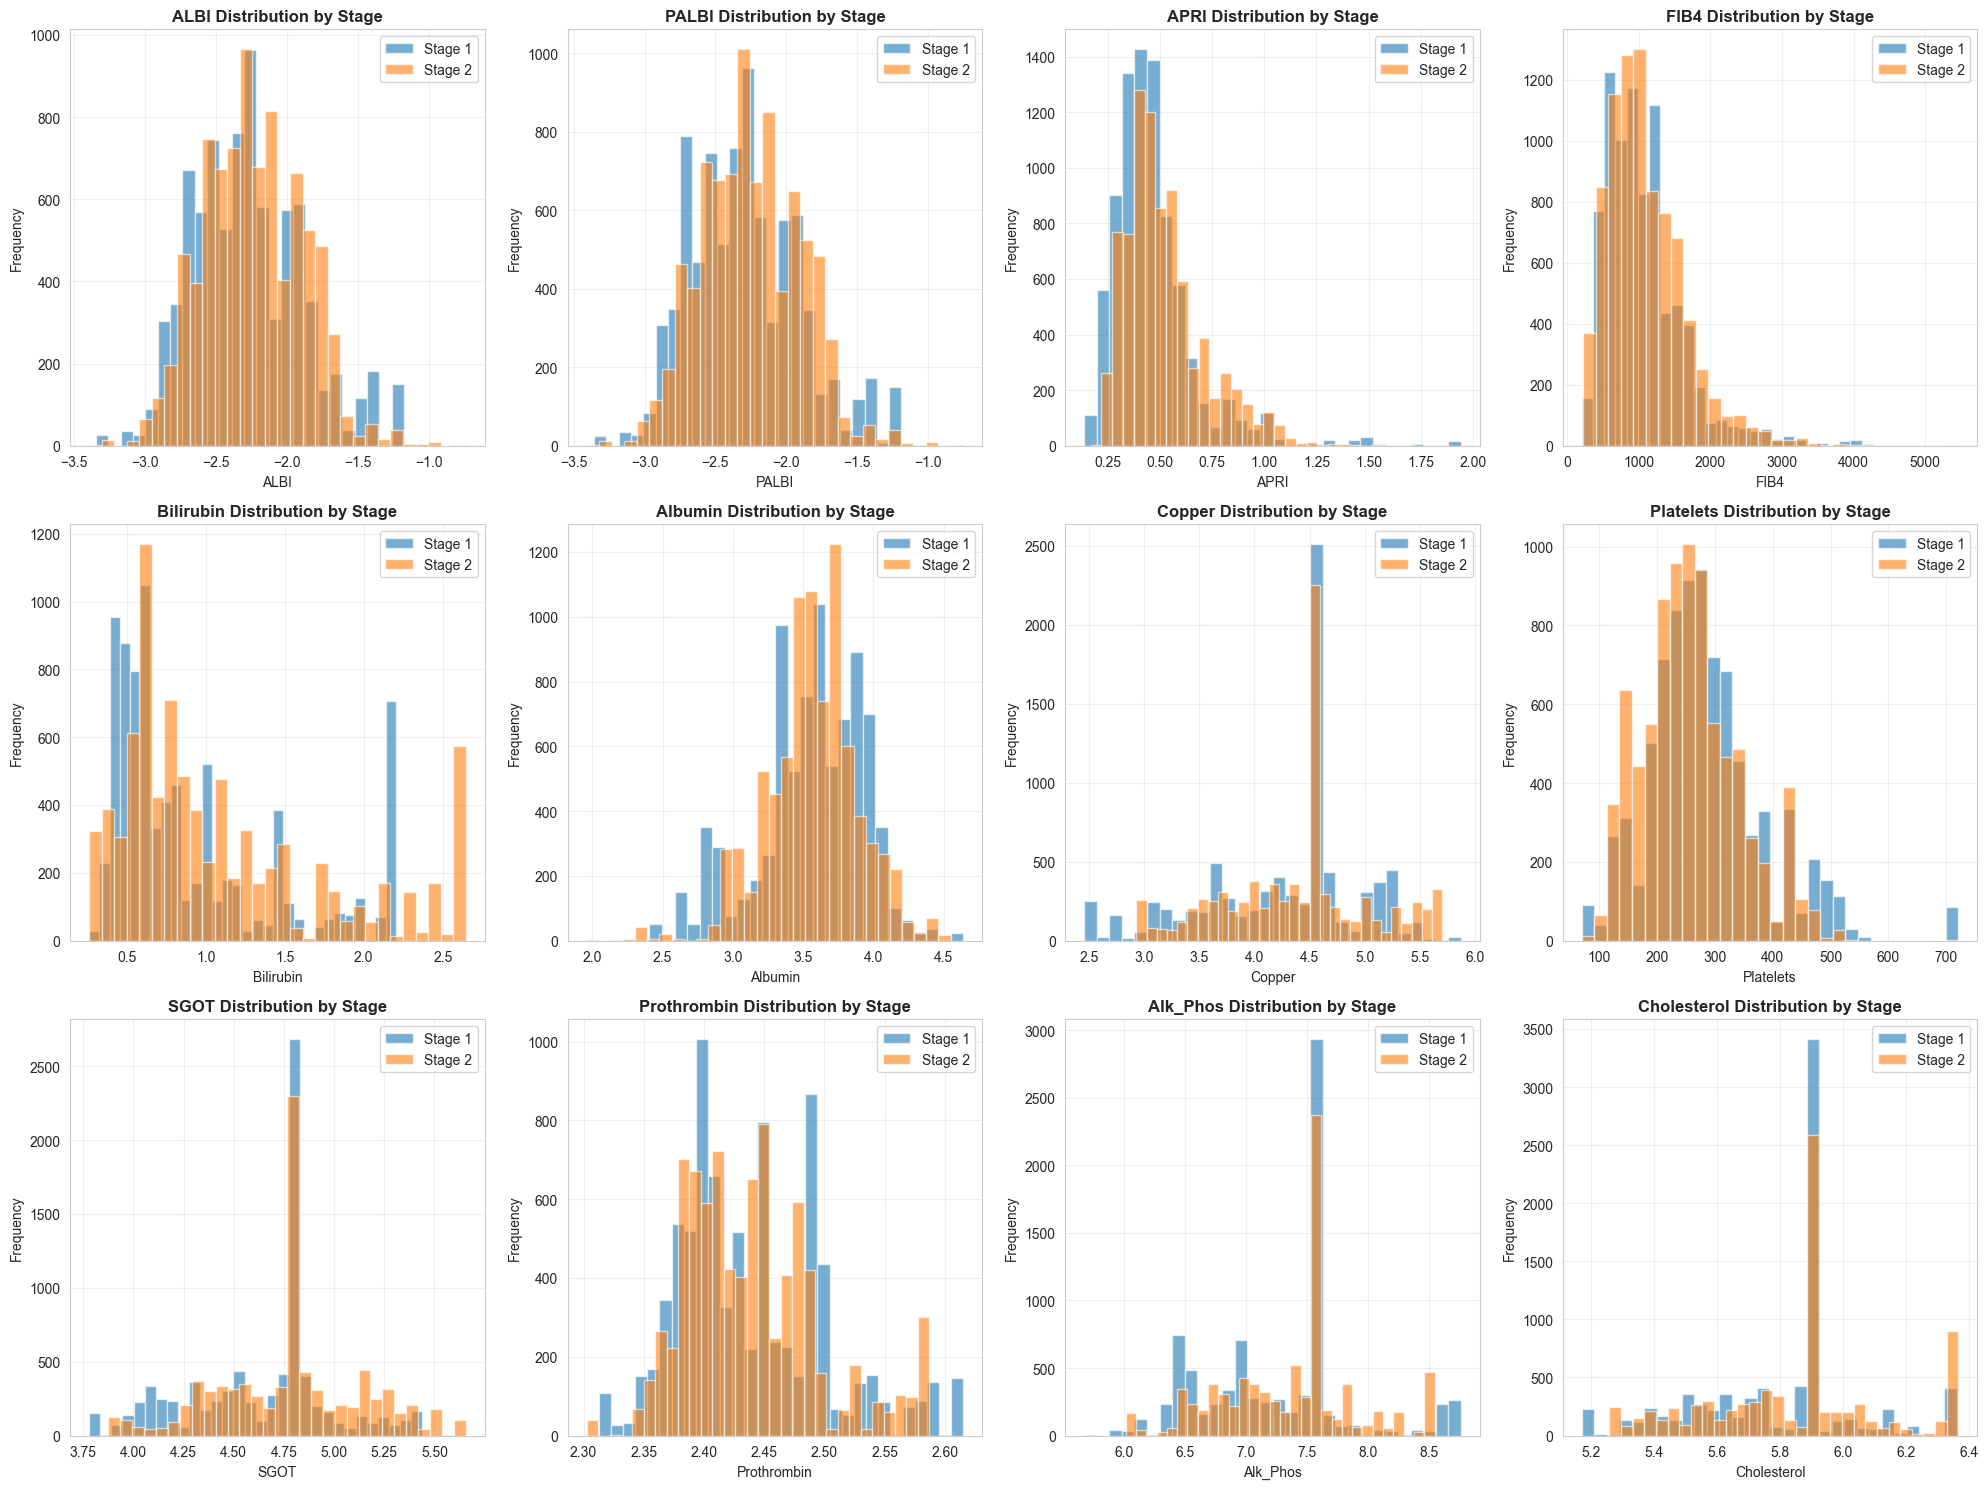


Correlation Analysis - Engineered Medical Features


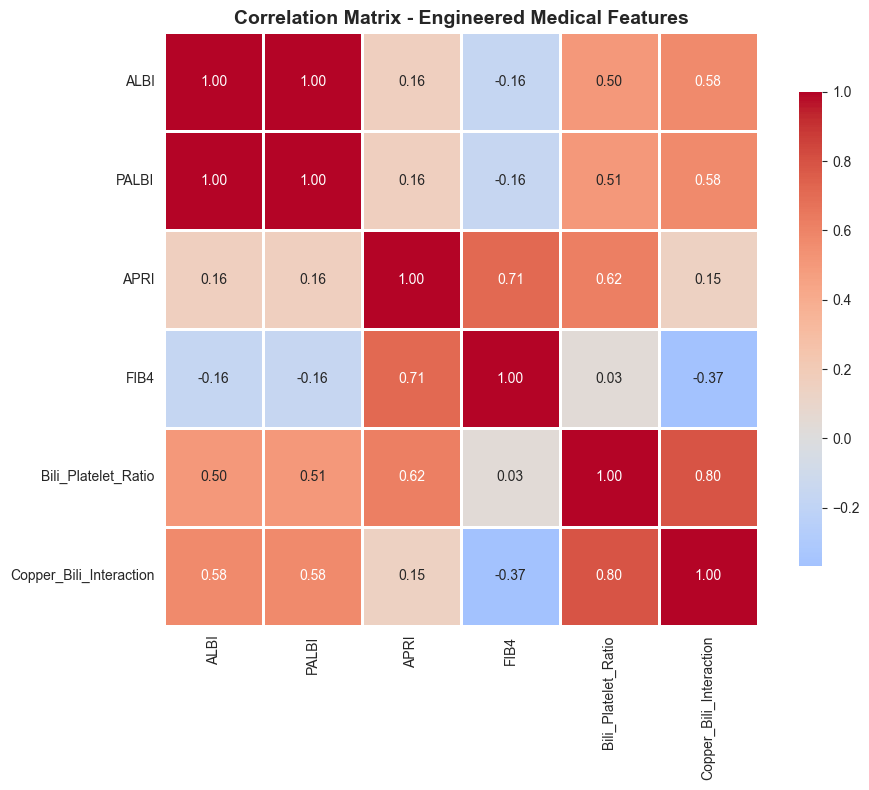

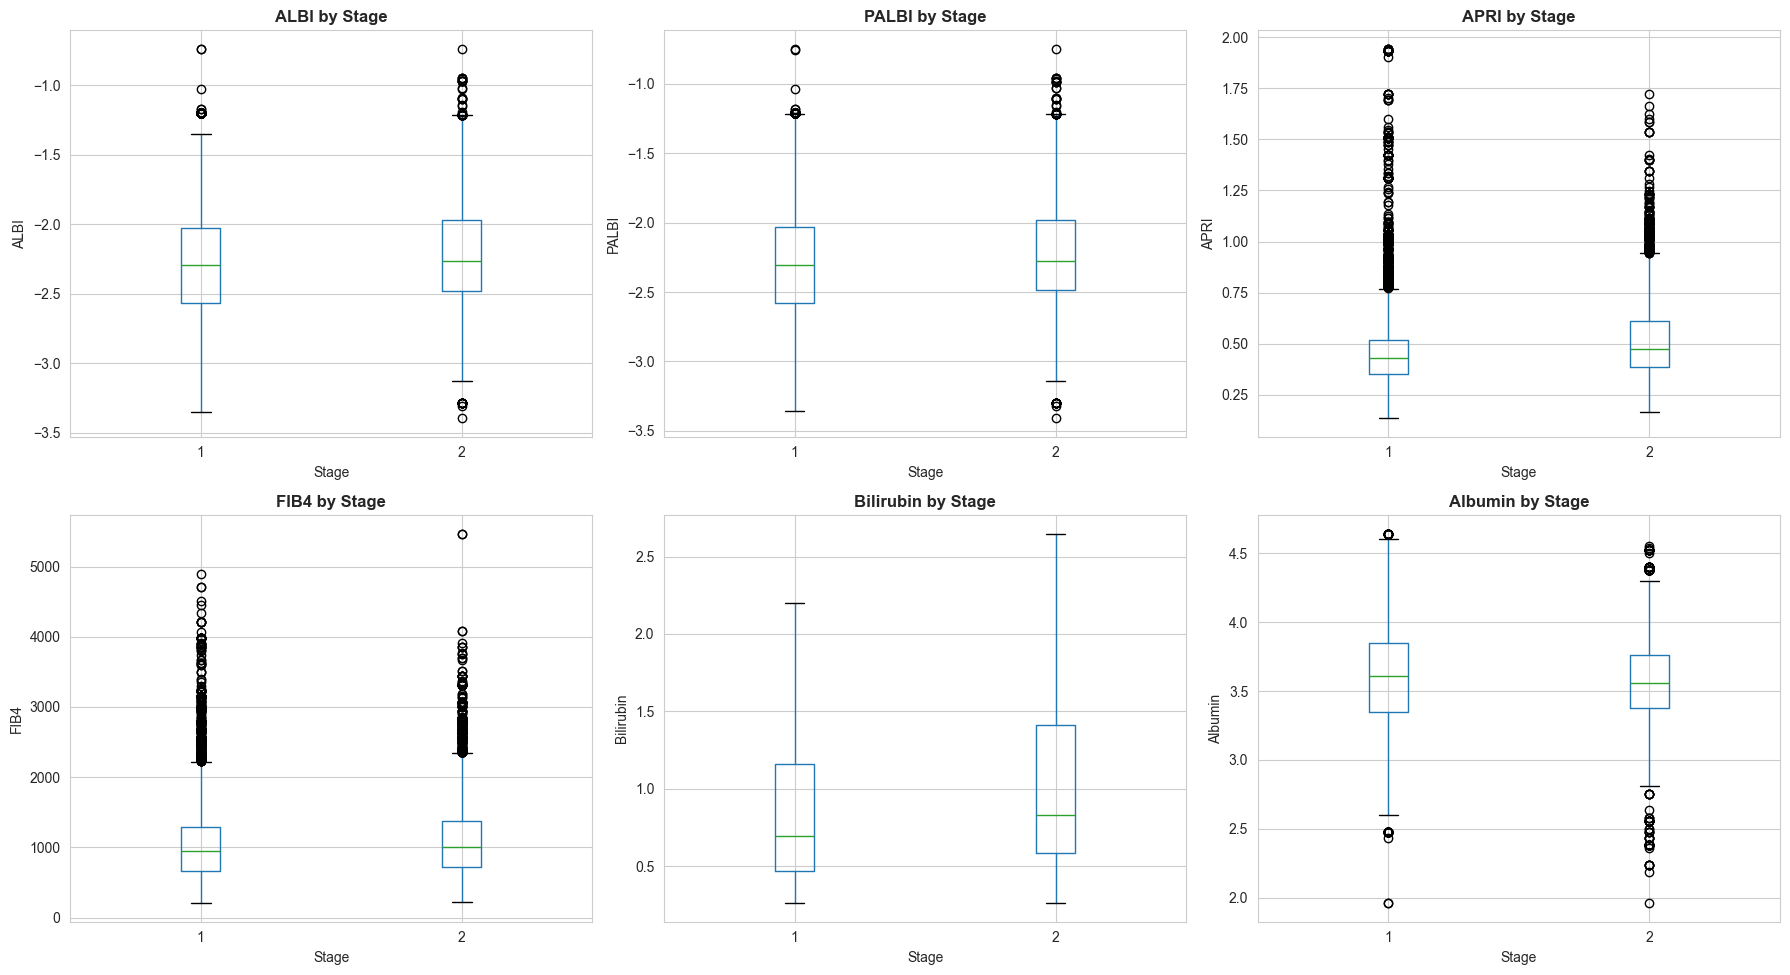


EDA Complete!


In [47]:
# EDA on All Features
print("="*70)
print("EXPLORATORY DATA ANALYSIS - ALL FEATURES")
print("="*70)

# Get all numeric features after feature engineering
numeric_features = df_d_fe.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove target and stage columns
numeric_features = [col for col in numeric_features if col not in ['Stage', 'Target']]

print(f"\nTotal numeric features: {len(numeric_features)}")
print(f"Features: {numeric_features}")

# Distribution plots for key medical features
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

key_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bilirubin', 'Albumin', 
                'Copper', 'Platelets', 'SGOT', 'Prothrombin', 'Alk_Phos', 'Cholesterol']

for idx, feature in enumerate(key_features[:12]):
    if feature in df_d_fe.columns:
        for stage in [1, 2]:
            stage_data = df_d_fe[df_d_fe['Stage'] == stage][feature].dropna()
            axes[idx].hist(stage_data, alpha=0.6, label=f'Stage {stage}', bins=30)
        axes[idx].set_title(f'{feature} Distribution by Stage', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap for engineered features
print("\nCorrelation Analysis - Engineered Medical Features")
engineered_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bili_Platelet_Ratio', 'Copper_Bili_Interaction']
if all(feat in df_d_fe.columns for feat in engineered_features):
    corr_matrix = df_d_fe[engineered_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Engineered Medical Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Box plots for stage comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

comparison_features = ['ALBI', 'PALBI', 'APRI', 'FIB4', 'Bilirubin', 'Albumin']
for idx, feature in enumerate(comparison_features):
    if feature in df_d_fe.columns:
        df_d_fe.boxplot(column=feature, by='Stage', ax=axes[idx])
        axes[idx].set_title(f'{feature} by Stage', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Stage')
        axes[idx].set_ylabel(feature)
        axes[idx].get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EDA Complete!")
print("="*70)


## 4. Preprocessing & Data Splitting

In [48]:
target_col = 'Target'
y = df_d_fe[target_col]

# Exclude intermediate, target, and treatment variables
drop_cols = ['Stage', 'Status', 'N_Days', 'Target', 'bili_umolL', 'alb_gL', 'Age', 'Age_Year', 'Drug', 'plt_1000uL']

X = df_d_fe.drop(columns=drop_cols)
y = df_d_fe[target_col]

# Handle Categorical
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Features: {X.shape[1]}")
print(f"Categorical: {len(categorical_cols)}, Numerical: {len(numeric_cols)}")

# Train/Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain: {X_train.shape}, Test: {X_test.shape}")
print(f"Train distribution:\n{y_train.value_counts().sort_index()}")
print(f"Test distribution:\n{y_test.value_counts().sort_index()}")

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', RobustScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

Features: 20
Categorical: 5, Numerical: 15

Train: (13364, 20), Test: (3342, 20)
Train distribution:
Target
0    6612
1    6752
Name: count, dtype: int64
Test distribution:
Target
0    1653
1    1689
Name: count, dtype: int64


## 5. Optuna Hyperparameter Tuning

In [49]:
print("Starting Optuna Tuning for Stage 1 vs 2 Classification...")

# Random Forest
def objective_rf_d(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'class_weight': 'balanced'
    }
    model = RandomForestClassifier(**param, random_state=42, n_jobs=-1)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf_d, n_trials=10)
best_rf_params = study_rf.best_params
best_rf_params['class_weight'] = 'balanced'

# XGBoost
def objective_xgb_d(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**param, random_state=42, verbosity=0)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb_d, n_trials=10)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'use_label_encoder': False, 'eval_metric': 'logloss'})

# LightGBM
def objective_lgbm_d(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'class_weight': 'balanced',
        'verbose': -1
    }
    model = LGBMClassifier(**param, random_state=42)
    pipeline = ImbPipeline([('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', model)])
    return cross_validate(pipeline, X_train, y_train, cv=3, scoring='f1_macro')['test_score'].mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm_d, n_trials=10)
best_lgbm_params = study_lgbm.best_params
best_lgbm_params.update({'class_weight': 'balanced', 'verbose': -1})

print("Best RF:", best_rf_params)
print("Best XGB:", best_xgb_params)
print("Best LGBM:", best_lgbm_params)

Starting Optuna Tuning for Stage 1 vs 2 Classification...
Best RF: {'n_estimators': 277, 'max_depth': 18, 'min_samples_split': 7, 'class_weight': 'balanced'}
Best XGB: {'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.190259407858471, 'subsample': 0.9175265338718108, 'scale_pos_weight': 1.9071584365689014, 'use_label_encoder': False, 'eval_metric': 'logloss'}
Best LGBM: {'n_estimators': 291, 'num_leaves': 55, 'max_depth': 12, 'learning_rate': 0.11613197490660981, 'class_weight': 'balanced', 'verbose': -1}


## 6. Ensemble Training & Evaluation

Training Ensemble (Model D - Stage 1 vs 2)...

Classification Report (Ensemble):
              precision    recall  f1-score   support

     Stage 1       0.98      0.96      0.97      1653
     Stage 2       0.96      0.98      0.97      1689

    accuracy                           0.97      3342
   macro avg       0.97      0.97      0.97      3342
weighted avg       0.97      0.97      0.97      3342


AUC Score: 0.9949


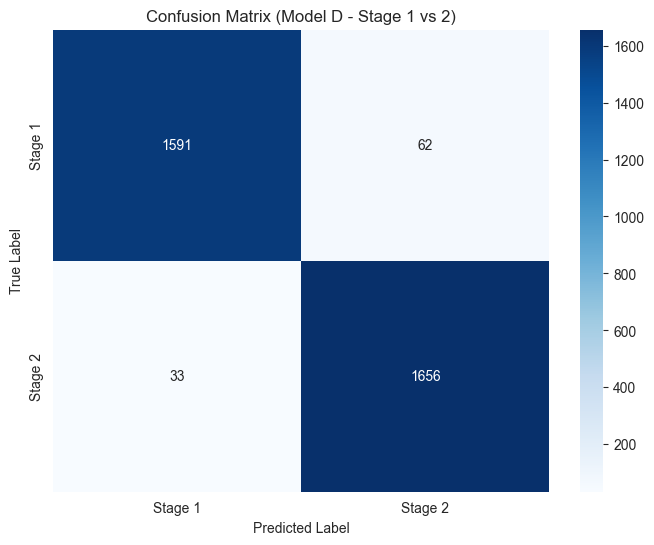


F1-Score: 0.9721


In [50]:
# Final Ensemble (Model D - Stage 1 vs 2)
model_rf = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble = VotingClassifier(
    estimators=[('rf', model_rf), ('xgb', model_xgb), ('lgbm', model_lgbm)],
    voting='soft'
)

final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble)
])

print("Training Ensemble (Model D - Stage 1 vs 2)...")
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred, target_names=['Stage 1', 'Stage 2']))
print(f"\nAUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stage 1', 'Stage 2'], yticklabels=['Stage 1', 'Stage 2'])
plt.title('Confusion Matrix (Model D - Stage 1 vs 2)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# F1 Score
f1 = f1_score(y_test, y_pred, average='binary')
print(f"\nF1-Score: {f1:.4f}")

## 7. Scaling Method Comparison\n\nCompare performance with different scaling methods: **No Scaling**, **StandardScaler**, **MinMaxScaler**

=== Scaling Method Comparison ===
Comparing: No Scaling, StandardScaler, MinMaxScaler

1️⃣ Training with No Scaling...
  AUC: 0.9948, F1: 0.9732, Acc: 0.9728

2️⃣ Training with StandardScaler...
  AUC: 0.9948, F1: 0.9724, Acc: 0.9719

3️⃣ Training with MinMaxScaler...
  AUC: 0.9947, F1: 0.9700, Acc: 0.9695

SCALING METHOD COMPARISON RESULTS
                     AUC        F1  Accuracy
No Scaling      0.994839  0.973243  0.972771
StandardScaler  0.994804  0.972385  0.971873
MinMaxScaler    0.994720  0.970018  0.969479


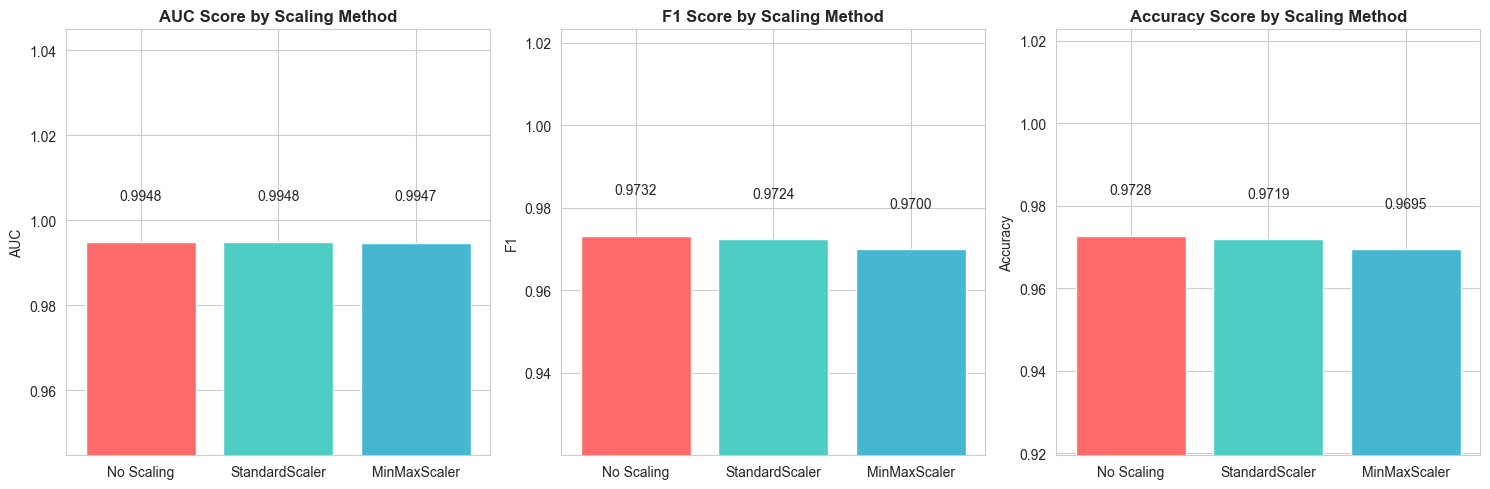


🏆 Best Scaling Method: No Scaling (F1: 0.9732)


In [51]:
print("=== Scaling Method Comparison ===")
print("Comparing: No Scaling, StandardScaler, MinMaxScaler\n")

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaling_results = {}

# 1. No Scaling (Passthrough)
print("1️⃣ Training with No Scaling...")
preprocessor_none = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model_rf_none = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb_none = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm_none = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble_none = VotingClassifier(
    estimators=[('rf', model_rf_none), ('xgb', model_xgb_none), ('lgbm', model_lgbm_none)],
    voting='soft'
)

pipeline_none = ImbPipeline([
    ('preprocessor', preprocessor_none),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble_none)
])

pipeline_none.fit(X_train, y_train)
y_pred_none = pipeline_none.predict(X_test)
y_proba_none = pipeline_none.predict_proba(X_test)[:, 1]

auc_none = roc_auc_score(y_test, y_proba_none)
f1_none = f1_score(y_test, y_pred_none, average='binary')
acc_none = accuracy_score(y_test, y_pred_none)

scaling_results['No Scaling'] = {
    'AUC': auc_none,
    'F1': f1_none,
    'Accuracy': acc_none
}

print(f"  AUC: {auc_none:.4f}, F1: {f1_none:.4f}, Acc: {acc_none:.4f}")

# 2. StandardScaler
print("\n2️⃣ Training with StandardScaler...")
preprocessor_std = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model_rf_std = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb_std = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm_std = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble_std = VotingClassifier(
    estimators=[('rf', model_rf_std), ('xgb', model_xgb_std), ('lgbm', model_lgbm_std)],
    voting='soft'
)

pipeline_std = ImbPipeline([
    ('preprocessor', preprocessor_std),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble_std)
])

pipeline_std.fit(X_train, y_train)
y_pred_std = pipeline_std.predict(X_test)
y_proba_std = pipeline_std.predict_proba(X_test)[:, 1]

auc_std = roc_auc_score(y_test, y_proba_std)
f1_std = f1_score(y_test, y_pred_std, average='binary')
acc_std = accuracy_score(y_test, y_pred_std)

scaling_results['StandardScaler'] = {
    'AUC': auc_std,
    'F1': f1_std,
    'Accuracy': acc_std
}

print(f"  AUC: {auc_std:.4f}, F1: {f1_std:.4f}, Acc: {acc_std:.4f}")

# 3. MinMaxScaler
print("\n3️⃣ Training with MinMaxScaler...")
preprocessor_minmax = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_cols),
    ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model_rf_mm = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
model_xgb_mm = XGBClassifier(**best_xgb_params, random_state=42)
model_lgbm_mm = LGBMClassifier(**best_lgbm_params, random_state=42)

ensemble_mm = VotingClassifier(
    estimators=[('rf', model_rf_mm), ('xgb', model_xgb_mm), ('lgbm', model_lgbm_mm)],
    voting='soft'
)

pipeline_mm = ImbPipeline([
    ('preprocessor', preprocessor_minmax),
    ('smote', SMOTE(random_state=42)),
    ('ensemble', ensemble_mm)
])

pipeline_mm.fit(X_train, y_train)
y_pred_mm = pipeline_mm.predict(X_test)
y_proba_mm = pipeline_mm.predict_proba(X_test)[:, 1]

auc_mm = roc_auc_score(y_test, y_proba_mm)
f1_mm = f1_score(y_test, y_pred_mm, average='binary')
acc_mm = accuracy_score(y_test, y_pred_mm)

scaling_results['MinMaxScaler'] = {
    'AUC': auc_mm,
    'F1': f1_mm,
    'Accuracy': acc_mm
}

print(f"  AUC: {auc_mm:.4f}, F1: {f1_mm:.4f}, Acc: {acc_mm:.4f}")

# Results Table
print("\n" + "="*60)
print("SCALING METHOD COMPARISON RESULTS")
print("="*60)
results_df = pd.DataFrame(scaling_results).T
print(results_df)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['AUC', 'F1', 'Accuracy']
for idx, metric in enumerate(metrics):
    values = [scaling_results[method][metric] for method in ['No Scaling', 'StandardScaler', 'MinMaxScaler']]
    axes[idx].bar(['No Scaling', 'StandardScaler', 'MinMaxScaler'], values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    axes[idx].set_title(f'{metric} Score by Scaling Method', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_ylim([min(values) - 0.05, max(values) + 0.05])
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Best method
best_method = max(scaling_results.items(), key=lambda x: x[1]['F1'])
print(f"\n🏆 Best Scaling Method: {best_method[0]} (F1: {best_method[1]['F1']:.4f})")


## 8. SHAP Analysis (Individual Models)\n\nSHAP analysis for each model (RF, XGB, LGBM) to understand feature importance and contributions.

### 8.1 Random Forest SHAP Analysis

SHAP ANALYSIS - RANDOM FOREST

Total features after transformation: 22


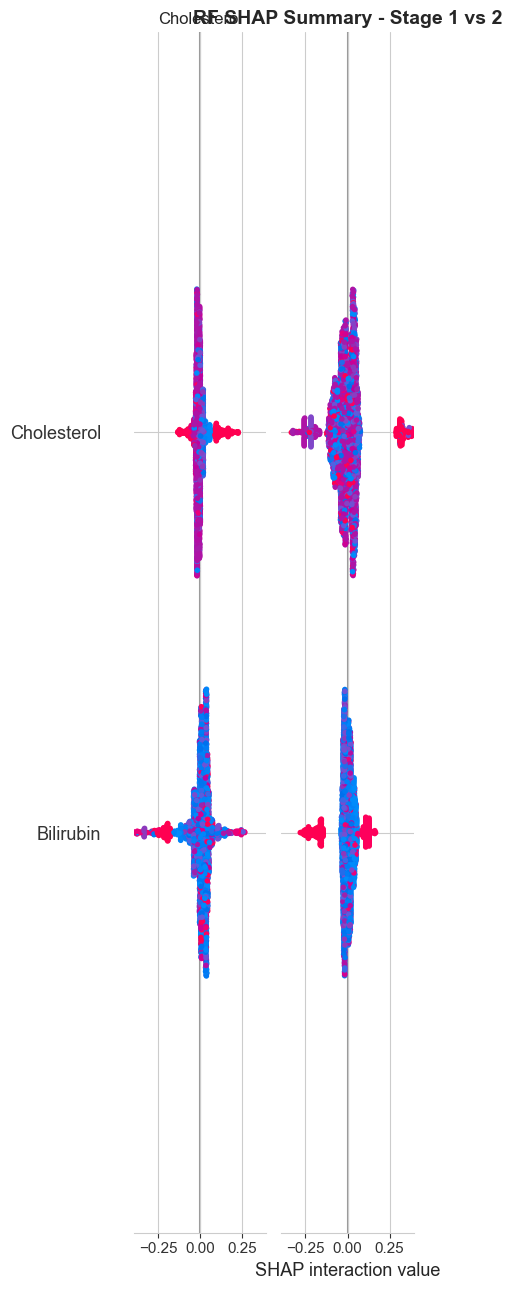

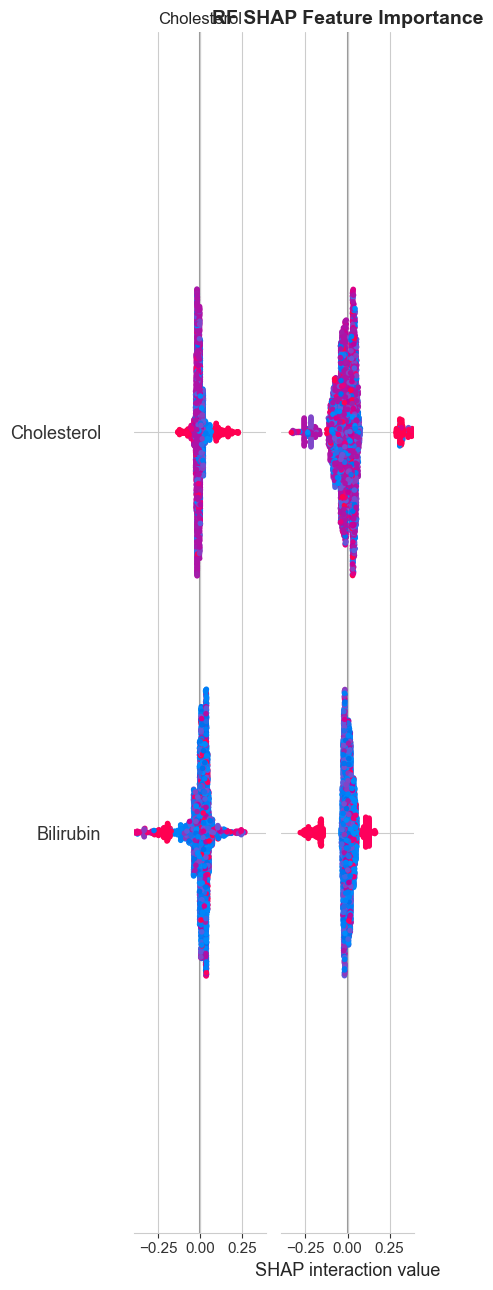


Random Forest SHAP Analysis Complete!


In [52]:
print("="*70)
print("SHAP ANALYSIS - RANDOM FOREST")
print("="*70)

# Train RF model with best params
model_rf_shap = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)

# Fit preprocessor and model
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Train model
model_rf_shap.fit(X_train_resampled, y_train_resampled)

# Get feature names after transformation
feature_names_transformed = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'num':
        feature_names_transformed.extend(features)
    elif name == 'cat':
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names_transformed.extend(transformer.get_feature_names_out(features))

print(f"\nTotal features after transformation: {len(feature_names_transformed)}")

# SHAP Explainer
explainer_rf = shap.TreeExplainer(model_rf_shap)
shap_values_rf = explainer_rf.shap_values(X_test_transformed)

# For binary classification
if isinstance(shap_values_rf, list):
    # Use class 1 (positive class) for binary
    shap_values_rf = shap_values_rf[1]

shap.summary_plot(shap_values_rf, X_test_transformed, 
                 feature_names=feature_names_transformed, show=False, max_display=15)
plt.title('RF SHAP Summary - Stage 1 vs 2', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Bar plot
shap.summary_plot(shap_values_rf, X_test_transformed, 
                 feature_names=feature_names_transformed, 
                 plot_type='bar', show=False, max_display=15)
plt.title('RF SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nRandom Forest SHAP Analysis Complete!")


### 8.2 XGBoost SHAP Analysis

SHAP ANALYSIS - XGBOOST


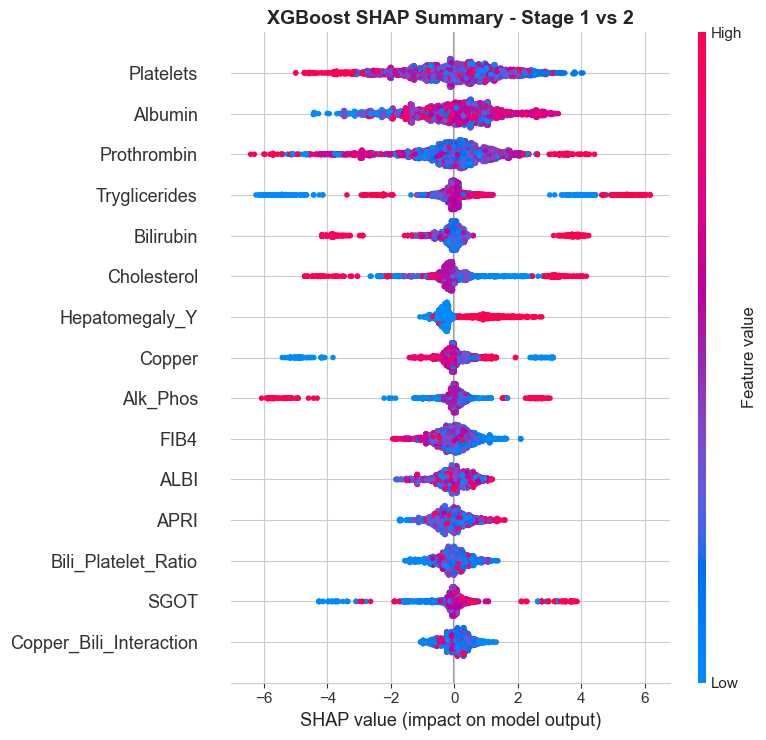

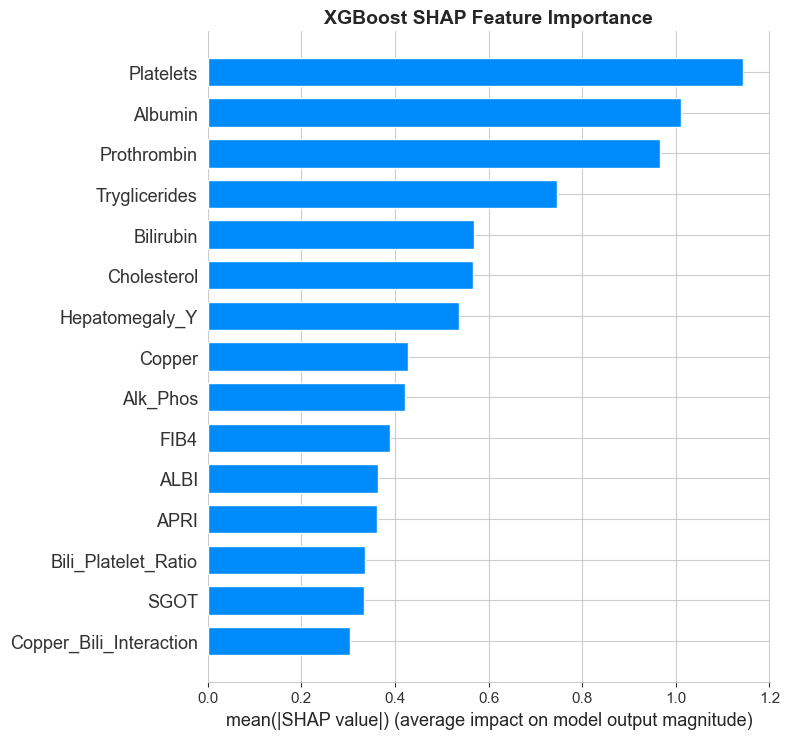


XGBoost SHAP Analysis Complete!


In [53]:
print("="*70)
print("SHAP ANALYSIS - XGBOOST")
print("="*70)

# Train XGB model with best params
model_xgb_shap = XGBClassifier(**best_xgb_params, random_state=42)

# Train model
model_xgb_shap.fit(X_train_resampled, y_train_resampled)

# SHAP Explainer
explainer_xgb = shap.TreeExplainer(model_xgb_shap)
shap_values_xgb = explainer_xgb.shap_values(X_test_transformed)

shap.summary_plot(shap_values_xgb, X_test_transformed, 
                 feature_names=feature_names_transformed, show=False, max_display=15)
plt.title('XGBoost SHAP Summary - Stage 1 vs 2', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Bar plot
shap.summary_plot(shap_values_xgb, X_test_transformed, 
                 feature_names=feature_names_transformed, 
                 plot_type='bar', show=False, max_display=15)
plt.title('XGBoost SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nXGBoost SHAP Analysis Complete!")


### 8.3 LightGBM SHAP Analysis

SHAP ANALYSIS - LIGHTGBM


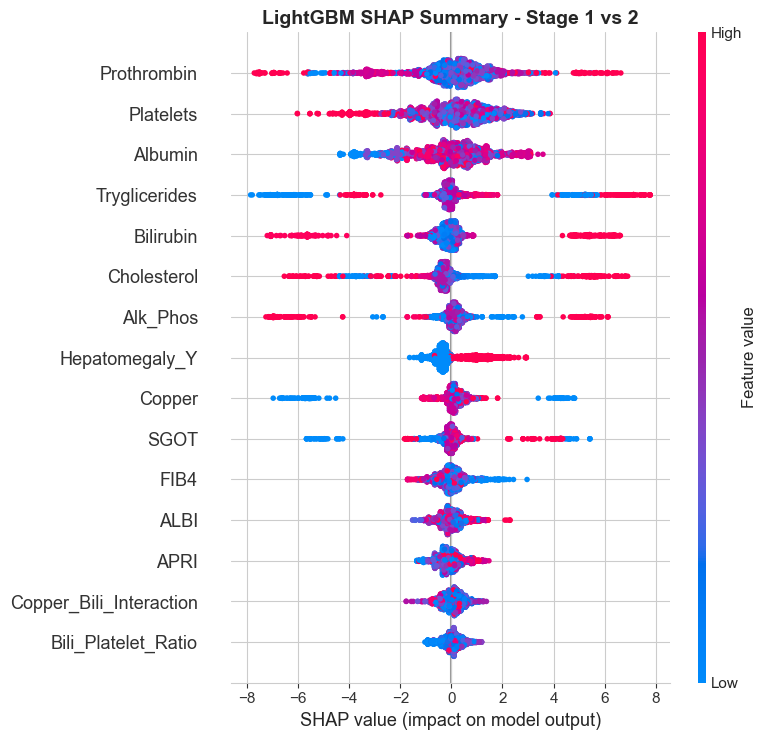

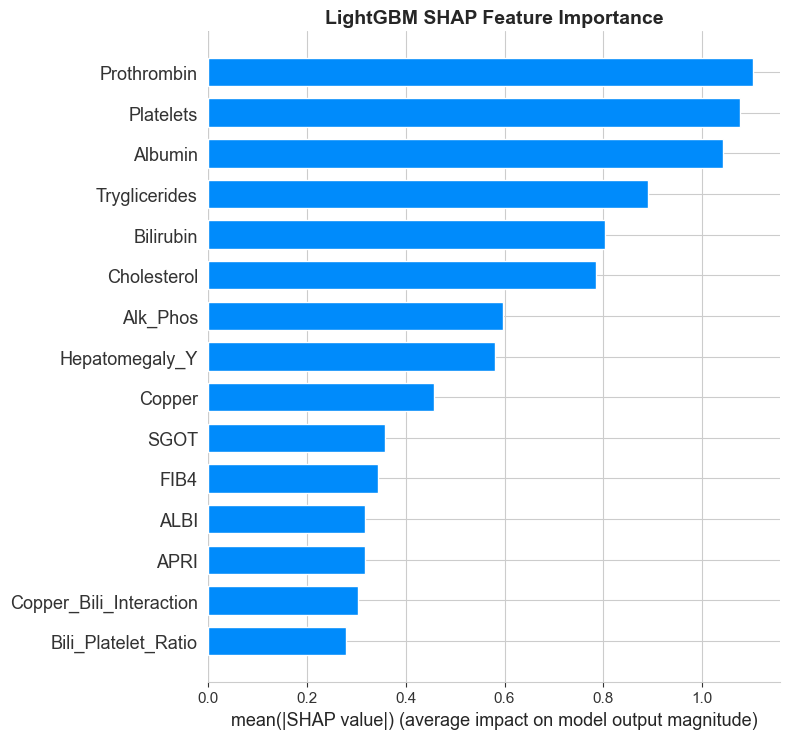


LightGBM SHAP Analysis Complete!


In [54]:
print("="*70)
print("SHAP ANALYSIS - LIGHTGBM")
print("="*70)

# Train LGBM model with best params
model_lgbm_shap = LGBMClassifier(**best_lgbm_params, random_state=42)

# Train model
model_lgbm_shap.fit(X_train_resampled, y_train_resampled)

# SHAP Explainer
explainer_lgbm = shap.TreeExplainer(model_lgbm_shap)
shap_values_lgbm = explainer_lgbm.shap_values(X_test_transformed)

# For binary classification
if isinstance(shap_values_lgbm, list):
    shap_values_lgbm = shap_values_lgbm[1]

shap.summary_plot(shap_values_lgbm, X_test_transformed, 
                 feature_names=feature_names_transformed, show=False, max_display=15)
plt.title('LightGBM SHAP Summary - Stage 1 vs 2', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Bar plot
shap.summary_plot(shap_values_lgbm, X_test_transformed, 
                 feature_names=feature_names_transformed, 
                 plot_type='bar', show=False, max_display=15)
plt.title('LightGBM SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nLightGBM SHAP Analysis Complete!")


### 8.4 SHAP Feature Importance Comparison

In [55]:
print("="*70)
print("SHAP FEATURE IMPORTANCE COMPARISON")
print("="*70)

# Extract mean absolute SHAP values for each model
import numpy as np

mean_shap_rf = np.abs(shap_values_rf).mean(axis=0)
mean_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
mean_shap_lgbm = np.abs(shap_values_lgbm).mean(axis=0)

# Create comparison DataFrame
# Ensure all arrays have the same length
n_features = len(mean_shap_rf)
print(f"Number of features: {n_features}")
print(f"Feature names length: {len(feature_names_transformed)}")

# If lengths don't match, truncate or pad feature names
if len(feature_names_transformed) != n_features:
    print(f"WARNING: Feature names ({len(feature_names_transformed)}) != SHAP values ({n_features})")
    if len(feature_names_transformed) > n_features:
        feature_names_transformed = feature_names_transformed[:n_features]
    else:
        # Pad with generic names
        feature_names_transformed.extend([f'feature_{i}' for i in range(len(feature_names_transformed), n_features)])

shap_comparison = pd.DataFrame({
    'Feature': feature_names_transformed,
    'RF_SHAP': mean_shap_rf,
    'XGB_SHAP': mean_shap_xgb,
    'LGBM_SHAP': mean_shap_lgbm
})

# Average SHAP across models
shap_comparison['Avg_SHAP'] = shap_comparison[['RF_SHAP', 'XGB_SHAP', 'LGBM_SHAP']].mean(axis=1)
shap_comparison = shap_comparison.sort_values('Avg_SHAP', ascending=False).head(20)

print("\nTop 20 Features by Average SHAP Importance:")
print(shap_comparison)

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(shap_comparison))
width = 0.25

ax.barh(x - width, shap_comparison['RF_SHAP'], width, label='Random Forest', color='#FF6B6B')
ax.barh(x, shap_comparison['XGB_SHAP'], width, label='XGBoost', color='#4ECDC4')
ax.barh(x + width, shap_comparison['LGBM_SHAP'], width, label='LightGBM', color='#45B7D1')

ax.set_yticks(x)
ax.set_yticklabels(shap_comparison['Feature'])
ax.set_xlabel('Mean Absolute SHAP Value', fontsize=12, fontweight='bold')
ax.set_title('SHAP Feature Importance Comparison (Top 20)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SHAP Analysis Complete for All Models!")
print("="*70)


SHAP FEATURE IMPORTANCE COMPARISON
Number of features: 22
Feature names length: 22


ValueError: Per-column arrays must each be 1-dimensional